# Stat-xplore statistics for Lewisham

Fetches labour market data

_This requires the `OA->LSOA` lookup table produced by `lbl_boundaries_oa.ipynb` as well as the `OA->WD22` lookup table produced by "`lbl_boundaries_2022_wards.ipynb`"_

# Setup

## Imports

In [2]:
%%capture
!pip install https://github.com/philipbrien/statxplorer/zipball/master

In [3]:
import statxplorer
key = "65794a30655841694f694a4b563151694c434a68624763694f694a49557a49314e694a392e65794a7063334d694f694a7a644849756333526c6247786863694973496e4e3159694936496d6c7563326c6e614851745957356b4c57526c62476c325a584a355147786c64326c7a614746744c6d64766469353161794973496d6c68644349364d54597a4e7a497a4d6a51344d5377695958566b496a6f69633352794c6d396b59534a392e764b6a5355767a594132314a374a6a5f31345076774f6243584a6178576a52303173634e68547238517863"
import json
explorer = statxplorer.StatXplorer(key)
# explorer.convert_to_dataframe

In [20]:
import os
import pandas as pd
import geopandas as gpd
import IPython
import matplotlib
import matplotlib.pyplot as plt

## Filesystem

In [5]:
# Determine if in google colab
def in_colab():
    return True if os.getenv("HOME") == "/root" else False

In [6]:
# Google Drive access
if in_colab():
    from google.colab import drive
    drive.mount("/content/gdrive")
    project_dir = "/content/gdrive/MyDrive/WardProfiles"
else:
    project_dir = "/Volumes/GoogleDrive/My Drive/WardProfiles"

print("project_dir:", project_dir)


project_dir: /Volumes/GoogleDrive/My Drive/WardProfiles


In [7]:
oa_lookups_dir = f"{project_dir}/lookups/oa"
ward_lookups_dir = f"{project_dir}/lookups/2022_wards"
oa_dir = f"{project_dir}/boundaries/oa"
ward_dir = f"{project_dir}/boundaries/2022_wards"

# For exports
output_dir = f"{project_dir}/universal_credit"

In [8]:
!mkdir -p '{output_dir}'

In [9]:
!ls '{output_dir}'

lbl_universal_credit_lsoa11.csv lbl_universal_credit_wd22.csv
lbl_universal_credit_oa11.csv   references_universal_credit.csv
lbl_universal_credit_refs11.csv table_2021-11-19_17-27-02.json


Downloads
--

```
Field:Households on Universal Credit

Description

The count is the number of households whose entitlement to Universal Credit has been calculated for an assessment period covering a given point in time.

Statistics are based on Universal Credit households in Great Britain on the count date.
```

In [10]:
# get the data from the statxplore api

def get_data(table='table_2021-11-19_17-27-02'):
    query = f'{output_dir}/{table}.json'
    results = explorer.fetch_table(query, reshape=False)
    data = results['data']
    return data

df = get_data()

In [11]:
df.head()

,National - Regional - LA - OAs,Month,Households on Universal Credit
0,London,August 2021,839611.0
1,England,August 2021,4250552.0
2,Lewisham,August 2021,35045.0
3,E00016460,August 2021,25.0
4,E00016463,August 2021,76.0


## Functions to transform data

In [12]:
# epoch - list of matching time values (e.g. 'August 2021')
# lbl_oa_list - filter list of matching labels (e.g. England, London...)
def filter_statxplore_data(d, date_values, geography_values):  
  # use the `Month` and `National - Regional  - LA - OAs`
  return d[d['Month'].isin(date_values) &
           d['National - Regional - LA - OAs'].isin(geography_values)]

In [13]:
def format_statxplore_data(d, geo_colname='National - Regional - LA - OAs'):
  return d.\
           rename(columns={'geography code': geo_colname})

In [14]:
# Convenience function to call the above two
def statxplore_to_oa(d, years, oa_list):
  return format_statxplore_data(filter_statxplore_data(d, years, oa_list))

In [15]:
# Aggregate OA-level data to LSOAs, Wards, etc. (Calculates the sum.)
def aggregate_oa_groups(oa_data, oa_group_table, oa_col, group_col):
  return pd.merge(oa_group_table, oa_data, on=oa_col, how='right').\
              drop(columns=[oa_col]).\
              groupby(group_col).sum()

Lookups
--
Used to match up OAs with their LSOAs, and 2022 electoral wards

In [16]:
# All OAs and their LSOAs in Lewisham
oa_lsoa_join = pd.read_csv(f"{oa_lookups_dir}/lbl_oa11_lsoa11_msoa11_lad20_rgn20_202012.csv")
oa_lsoa_join = oa_lsoa_join[['OA11CD', 'LSOA11CD']]
oa_lsoa_join.head()

,OA11CD,LSOA11CD
0,E00016277,E01003220
1,E00016278,E01003220
2,E00016285,E01003220
3,E00016257,E01003221
4,E00016263,E01003221


In [17]:
# All OAs and their 2022 wards in Lewisham
oa_wd22_join = pd.read_csv(f"{ward_lookups_dir}/lbl_oa11_wd22_proposed.csv")
oa_wd22_join = oa_wd22_join[['OA11CD', 'WD22CD_proposed']]
oa_wd22_join.head()

,OA11CD,WD22CD_proposed
0,E00016403,E05013721
1,E00016442,E05013721
2,E00016407,E05013721
3,E00016404,E05013721
4,E00016402,E05013721


Process & export
==

In [18]:
epoch = ['August 2021']
lbl_oa_list = oa_lsoa_join.OA11CD.unique()
oas = filter_statxplore_data(df,epoch,lbl_oa_list)
d = statxplore_to_oa(oas, epoch,lbl_oa_list)

for datname in ['universal_credit']:
  IPython.display.display(f"=== {datname} ===")

  # Transform to OA index data
  lbl_oa = statxplore_to_oa(d, epoch, lbl_oa_list)
  lbl_oa = lbl_oa.rename(columns={'National - Regional - LA - OAs': 'OA11CD'})
  lbl_oa.to_csv(f"{output_dir}/lbl_{datname}_oa11.csv", index=False)
  IPython.display.display(lbl_oa.head())

  # Aggregate to LSOA level
  lbl_lsoa = aggregate_oa_groups(oa_data=lbl_oa, oa_group_table=oa_lsoa_join, oa_col="OA11CD", group_col='LSOA11CD')
  lbl_lsoa.to_csv(f"{output_dir}/lbl_{datname}_lsoa11.csv", index=True)
  IPython.display.display(lbl_lsoa.head())

  # Aggregate to WD22 level  
  
  lbl_wd22 = aggregate_oa_groups(oa_data=lbl_oa, oa_group_table=oa_wd22_join, oa_col="OA11CD", group_col='WD22CD_proposed')
  lbl_wd22.to_csv(f"{output_dir}/lbl_{datname}_wd22.csv", index=True)
  IPython.display.display(lbl_wd22.head())

  # Reference geographies  
  refs = filter_statxplore_data(df,epoch,['Lewisham','London','England'])
  refs = refs.rename(columns={'National - Regional - LA - OAs': 'Name'})
  refs.to_csv(f"{output_dir}/references_{datname}.csv", index=False)
  IPython.display.display(refs.head())


'=== universal_credit ==='

,OA11CD,Month,Households on Universal Credit
3,E00016460,August 2021,25.0
4,E00016463,August 2021,76.0
5,E00016467,August 2021,15.0
6,E00016469,August 2021,26.0
7,E00016471,August 2021,71.0


,Households on Universal Credit
LSOA11CD,
E01003189,265.0
E01003190,352.0
E01003191,246.0
E01003192,279.0
E01003193,198.0


,Households on Universal Credit
WD22CD_proposed,
E05013714,1794.0
E05013715,1517.0
E05013716,2121.0
E05013717,1719.0
E05013718,1375.0


,Name,Month,Households on Universal Credit
0,London,August 2021,839611.0
1,England,August 2021,4250552.0
2,Lewisham,August 2021,35045.0


## Spatial

In [21]:
# Ward22 geometry
wd22 = gpd.read_file(f"{ward_dir}/lbl_wd22_proposed.gpkg")
len(wd22)

19

In [24]:
# OA geometry
oa11 = gpd.read_file(f"{oa_dir}/lbl_oa11_20m.gpkg")
len(oa11)

887

In [26]:
universal_credit_oa_geom = oa11.merge(lbl_oa, left_on='OA11CD', right_on='OA11CD')


# Output

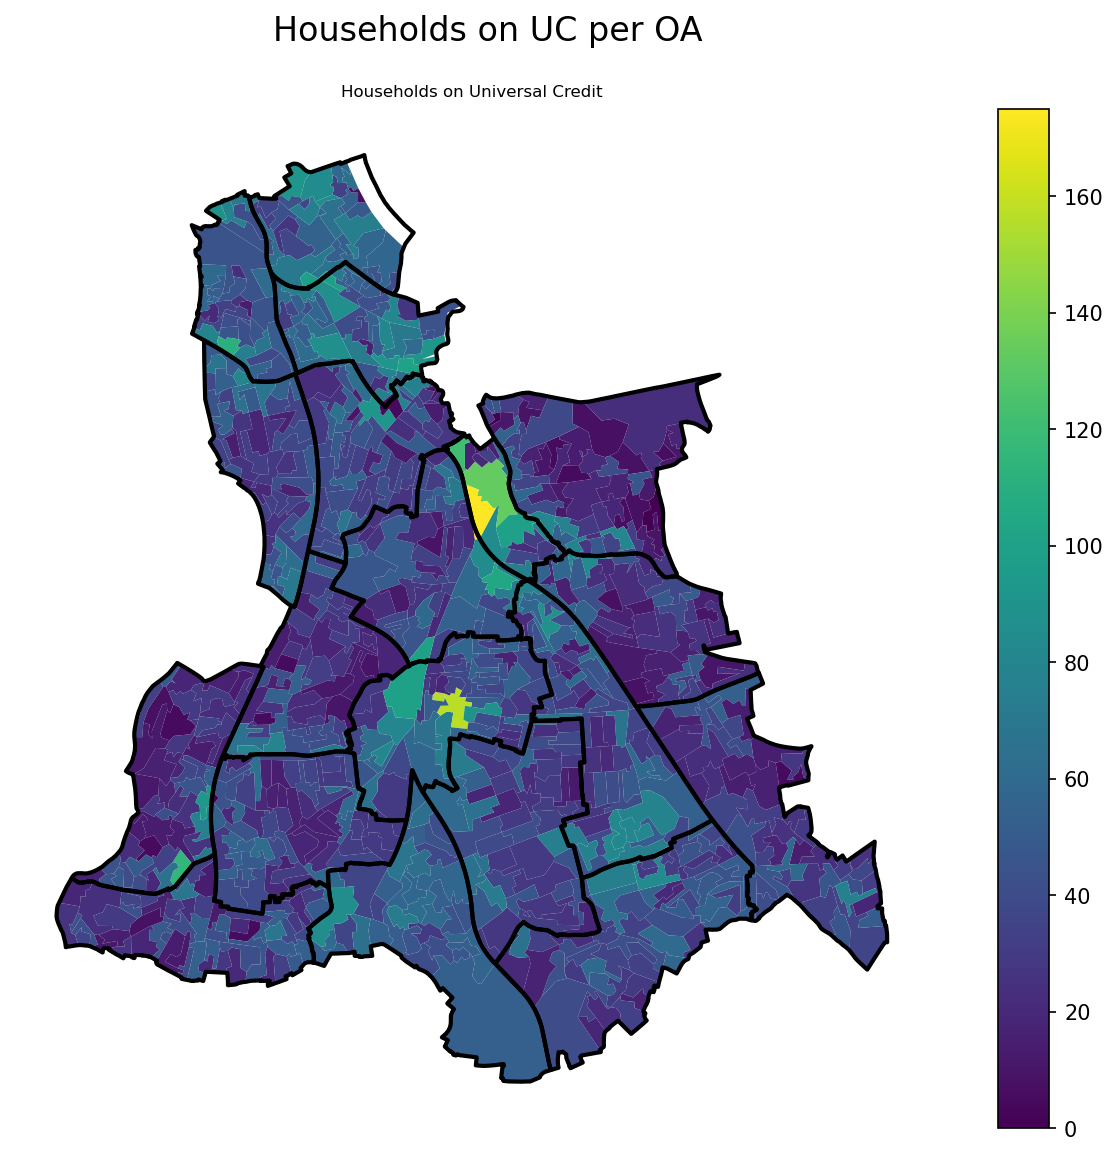

In [29]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=150)
plt.suptitle('Households on UC per OA', fontsize=16, y=.95)
plt.title('Households on Universal Credit', fontsize=8)
universal_credit_oa_geom.plot(ax=ax, column="Households on Universal Credit", legend=True)
plt.axis('off')
wd22.plot(ax=ax, facecolor='none', linewidth=2, edgecolor='black')

plt.savefig(f"{output_dir}/lbl_oa11_universal_credit.png", dpi=600)
plt.savefig(f"{output_dir}/lbl_oa11_universal_credit.pdf")